# Prediction of RNA binding sites

## Background

### 1) Biological importance of RNA binding proteins
**RNA binding proteins** (RBPs) control several steps of cellular RNA metabolism, such as splicing, transcript stability, translation and others. RBPs recognize and bind RNA molecules often in a motif-specific way. This means that the RNA targets of an RBP share at least one common local sequence or structure preference - so-called **motif** - which facilitates the recognition of the RNA by the protein.

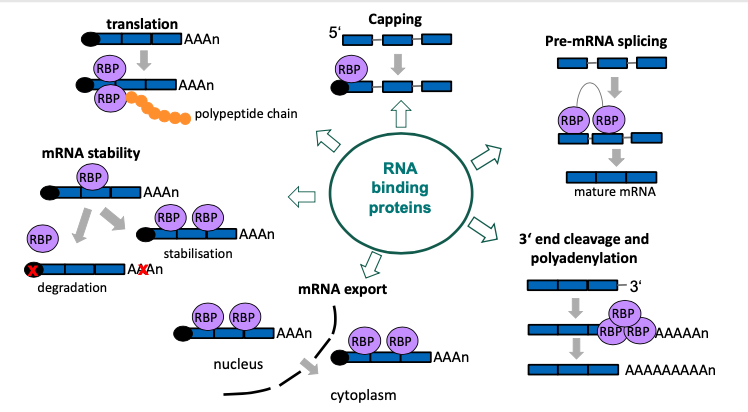

<img src="https://zhanglab.c2b2.columbia.edu/mCrossBase/static/plots/logo/K562.IGF2BP1.top10.cluster.m1.01.svg" width=400px>

### 2) Experimental identification of binding sites 
Due to their crucial role in cellular processes, **Cross-linking immunoprecipitation** (CLIP) method has been developed to experimentally map RBPs binding sites on a genome wide scale to understand their role in post transcriptional-regulatory machinery. In the experiments, RBP bound to RNA are cross-linked using UV light forming covalent bonds, then the cells are lysed and the RNA binding protein (together with the RNA segment) of interest are isolated over immunoprecipitation. The cross-linked RNA can then be separated from the protein and sequenced to identify the binding sites.



<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnmeth.3810/MediaObjects/41592_2016_Article_BFnmeth3810_Fig1_HTML.jpg?as=webp" width=600>

### 3) Computational prediction of binding sites
As some transcripts might not be expressed in the cell line of the CLIP-seq experiment, an active field of research is the computational prediction of binding sites on a given RNA sequence. Often **Convolutional Neural Network** (CNN) architectures that originated from the domain of computer vision are used, as the nucleotides on a RNA sequence can be seen as analogous to the pixels of an image. For today's exercise, this is exactly what we will be doing. **We will build and train a binary model to predict the binding of one RBP (called QKI) on a given 150 bp long RNA sequence.**

The data used for training comes from [eCLIP](https://www.nature.com/articles/nmeth.3810) experiments as part of the [ENCODE project](https://www.encodeproject.org/). **Positive samples** are obtained by extending a binding site/peak identified in eCLIP to both sides until 150 bp of sequence length are reached. **Negative samples** in this example come from positive binding segments from **other** RBPs. This is to correct for cross-linking biases in the CLIP-seq experiment. In practice, negative sites are often sampled from both unbound and bound regions. For simplicity (and to reduce training time), we omitted them here.

## **What you will learn today:**

*   How to load and encode sequence data (FASTA)
*   How to create a DL model via Pytorch
*   How to train the model and evaluate its performance
*   How to tune hyperparameters via Optuna
*   How to interrogate the model via feature attributions



## **Let's Code!**

### Preparing the Environment

#### Install Package(s)

#### Package Requirements

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
# PyTorch equivalent used below

To import the supplied data, i.e. the `data.fasta` file, into your Colab workspace, perform the following steps: 

1. Download the 'data' directory we've shared via Google Drive
2. Execute the code-cell below
3. Select and upload the 'data.fasta' file
4. The files are now in the working directory (i.e. `./`)

In [2]:
file_path = 'data.fasta'

with open(file_path, 'r') as f:
    fasta_content = f.read()

In [3]:
print('\n'.join(fasta_content.splitlines()[:8]))

>1
GATTACAGGAAACCCAACGGTGAGGTGGGCCGAGGTACCCTCGTGGCCGGGTCTGAGCATGAAGACCCTCCTCAGTGGCAGGAGGGCTGGTGAGGGGTCTGGCAGGTTTCAGGGGTGGCCGGTGGCCCTGAGCACGGTCAGGTGCAGTGA
>0
CGCCGGCTCCCTCCGGCAGCAGGGAGATGCGCGCCTGCGCCGGCCCTCGCCTCGGAGCAGCCATGATGGTGGGTGTTCTCCGCGGCGCCGAGTCCCGGGAGCGCGGTGGGGGCAGCGGGCGCGGGGCGGGCGCGGGGACCGCGCCAGCCT
>1
TTTCTCAGTGGCCTAGCCTGAGAGTTTATGGTGAGCGTGGTGTGGCTTTGCCAGGGGTGGGCTCAACCTATTTGTCAGGTGGCAGACACATCTGTGCATGTGGTGGGTCAGCCAACTTGGGTTCTGGTTTGCTAGGATTGGGGCCATGAG
>0
TTCTGTTTTGTTTTGTTTTAATCTTAGCTTTTAATAGTGTCATAAAGATTATAATATGTGCCTTAAGTTTTAGTCTTTAGAACTCTAGAGAGCCTTAACTTCTTAAACCATTTTTGCTGAATTCATCTATTTCGAGTGTTGTGTTAAAAG


In order to train a model with Tensorflow, we first have to load and preprocess the raw sequence data, which comes in the form of a FASTA file. 

Below are the first two lines of the 'data.fasta' file:

```
>1
GATTACAGGAAACCCAACGGTGAGGTGGGCCGAGGTACCCTCGTGGCCGGGTCTGAGCATGAAGACCCTCCTCAGTGGCAGGAGGGCTGGTGAGGGGTCTGGCAGGTTTCAGGGGTGGCCGGTGGCCCTGAGCACGGTCAGGTGCAGTGA
>0
CGCCGGCTCCCTCCGGCAGCAGGGAGATGCGCGCCTGCGCCGGCCCTCGCCTCGGAGCAGCCATGATGGTGGGTGTTCTCCGCGGCGCCGAGTCCCGGGAGCGCGGTGGGGGCAGCGGGCGCGGGGCGGGCGCGGGGACCGCGCCAGCCT
```

The file consists of sequences of length 150, centered around binding sites of the QKI RNA-binding protein. The non-unique header indicates whether the given sequence represents a positive or negative instance (i.e. label).

**Question: How many samples are there each for positive and negative instances?**

The goal of this section is to load samples in the 'data.fasta' file into a tf.data.Dataset for fast processing by Tensorflow. We will first write a function ('load_fasta') that iterates through lines of the FASTA file and returns arrays of one-hot encoded sequences and labels. Afterwards, we will use those arrays to instantiate a tf.data.Dataset

**Question: How does the one hot encoding look like for an example sequence of 'AGTTCG'?**

**Task 1:** Write a generator function that reads in a FASTA file and yields a tuple of (one-hot sequence, label). 

*Hint: In order to one-hot encode the DNA sequence, you first need to convert it to a sequence of integers. Afterwards, you can use* `numpy's one hot` *for one-hot encoding the integer list. Or alternatively just define a manual list* 

In [4]:
"""
Convention in one-hot-encoding:

A: 1,0,0,0
C: 0,1,0,0
G: 0,0,1,0
T: 0,0,0,1
"""

'\nConvention in one-hot-encoding:\n\nA: 1,0,0,0\nC: 0,1,0,0\nG: 0,0,1,0\nT: 0,0,0,1\n'

In [5]:
 def seq_to_onehot(sequence):
     bases = np.array(['A', 'C', 'G', 'T'])
     seq_array = np.array(list(sequence))
     return (seq_array[:, None] == bases[None, :]).astype(int)

In [6]:
def load_data(fasta):
    X = []
    Y = []
    with open(file_path, 'r') as f:
        lines = f.read().strip().splitlines()
    for i in range(0, len(lines), 2):
        label = int(lines[i][1:])        # remove'>'
        seq = lines[i+1].strip()         # seq itself
        X.append(seq_to_onehot(seq))     # (150, 4)
        Y.append(label)
    return np.array(X), np.array(Y)

In [7]:
X,Y = load_data('data.fasta')

In [8]:
X.shape,Y.shape

((19403, 150, 4), (19403,))

**Task 2:** Create a torch Dataset, using Dataset and Dataloader


In [9]:

from torch.utils.data import Dataset, DataLoader

class SimpleDataset(Dataset):
    def __init__(self, X, Y):
        # X: numpy array (N, 150, 4)
        # Y: numpy array (N,)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = SimpleDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


### Model Construction

**Task 3:** Build a model using the Torch. For a given input 150x4 input matrix, the model shall predict the probability that the sequence is bound / unbound by QKI. Try to implement the architecture displayed below. 

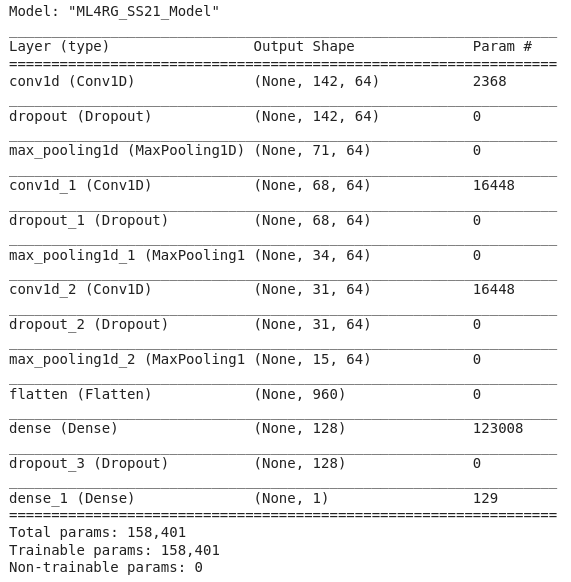

*Hint: consider nn.Conv1d and nn.Sequential if you want to chain better.*



**Question: Do you have an intuition about what the kernels learn, knowing that kernels in classical computer vision learn edges/lines or higher level abstract shapes of the images?**

In [10]:
"""
One kinda needs to trial and error their way to get the right kernel sizes
"""

'\nOne kinda needs to trial and error their way to get the right kernel sizes\n'

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RBP_binding_motif(nn.Module):
    def __init__(self):
        super(RBP_binding_motif, self).__init__()
        # Convolution1D(input_shape=(150,4), kernel_size=9, filters=64)
        # PyTorch Conv1d: (in_channels, out_channels, kernel_size)
        self.num_filters = 64
        self.kernel_size_1 = 9
        self.kernel_size_2 = 4
        self.hidden_dim = 128
        self.dropout_p = 0.5

        #input: (N, 4, 150) 
        self.conv1 = nn.Conv1d(
            in_channels=4,
            out_channels=self.num_filters,
            kernel_size=self.kernel_size_1
        ) # (N, 64, 120)
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.pool1 = nn.MaxPool1d(kernel_size=2) # (N, 64, 71)

        self.conv2 = nn.Conv1d(
            in_channels=self.num_filters,
            out_channels=self.num_filters,
            kernel_size=self.kernel_size_2
        ) #(N, 64, 68)
        self.dropout2 = nn.Dropout(self.dropout_p)
        self.pool2 = nn.MaxPool1d(kernel_size=2) # (N, 64, 34)

        self.conv3 = nn.Conv1d(
            in_channels=self.num_filters,
            out_channels=self.num_filters,
            kernel_size=self.kernel_size_2
        ) # (N, 64, 31)
        self.dropout3 = nn. Dropout(self.dropout_p)
        self.pool3 = nn.MaxPool1d(kernel_size=2) # (N, 64, 15)

        # 15*64=960
        self.flatten_dim = 15 * self.num_filters
        self.fc1 = nn.Linear(self.flatten_dim, self.hidden_dim) # 128
        self.dropout4 = nn.Dropout(self.dropout_p)
        self.fc_out = nn.Linear(self.hidden_dim, 1)

        
    def forward(self, x):
        # x: (batch_size, seq_len=150, channels=4) in TF style
        # PyTorch Conv1d expects (batch, channels, length)
        x = x.permute(0, 2, 1)  # (B, 4, 150)
        
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.dropout3(x)
        x = self.pool3(x)
        
        # flatten
        x = x.view(x.size(0), -1)  # (B, 960)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)

        # output p(0,1)
        x = torch.sigmoid(self.fc_out(x)).squeeze(1)
        return x



model = RBP_binding_motif().to(DEVICE)
# Binary cross-entropy loss (same as "binary_crossentropy")
criterion = nn.BCELoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Your model can be different than what we've shown
print(model)


RBP_binding_motif(
  (conv1): Conv1d(4, 64, kernel_size=(9,), stride=(1,))
  (dropout1): Dropout(p=0.5, inplace=False)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(4,), stride=(1,))
  (dropout2): Dropout(p=0.5, inplace=False)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(4,), stride=(1,))
  (dropout3): Dropout(p=0.5, inplace=False)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=960, out_features=128, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)


### Training and Evaluation

**Task 4:** Split the dataset into train, validation and test set using a ratio of 70/15/15. 


**Question: Why do we need to make this data split?**

**Why We Split the Dataset**

To prevent overfitting and ensure that the model’s performance reflects **true generalization**, not memorization, the dataset is divided into three independent subsets.

---

**1. Training Set (70%) — Model Learning**
- Used to **optimize model parameters** (weights and biases).  
- The model *sees* these sequences and learns statistical patterns.
- Represents the data the model directly trains on.

---

**2. Validation Set (15%) — Hyperparameter Tuning**
- Used to tune:
  - Learning rate  
  - Dropout  
  - Network architecture  
  - Early stopping  
- The validation set **does not update model weights**.  
- Helps prevent overfitting to the training data.

---

**3. Test Set (15%) — Final Unbiased Evaluation**
- Used **only once**, after all training and tuning are complete.  
- Simulates performance on **never-seen-before RNA sequences**.  
- Provides an **unbiased estimate** of model generalization ability.


In [13]:
from torch.utils.data import random_split, DataLoader

# Suppose `dataset` is your PyTorch Dataset of length N
n_samples = len(dataset)

# Compute split lengths
train_len = int(n_samples * 0.70)
val_len   = int(n_samples * 0.15)
test_len  = n_samples - train_len - val_len

# Perform the splits
dataset_train, dataset_val, dataset_test = random_split(
    dataset,                # dataset to be splited
    [train_len, val_len, test_len],   # length
    generator=torch.Generator().manual_seed(42)  # reproducible
)


In [14]:
# Wrap in DataLoaders
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=64, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=64, shuffle=False)

**Task 6:** Train the model for 20 epochs and monitor the validation-set loss and accuracy. 

*Hint: Use* Training loop help provided*.* 

You'll have to define the learning rate manually, feed model.parameters into optim.Adam for ease.

**Question: Has a good accuracy been achieved after 20 epos? What does it mean?**


- **If the validation accuracy is close to 0.5**: similar to random guessing, indicating that the model has not learned meaningful patterns for QKI-binding motifs.

- **If the validation accuracy is above 0.8**: the model can already distinguish bound vs. unbound sequences reasonably well.

- **If the validation accuracy exceeds 0.9**, and the **validation loss is also low** with **no obvious overfitting**: the model can be considered to have strong capability in recognizing QKI-binding motifs.


Validation accuracy is computed by converting model outputs into binary predictions using a 0.5 threshold, comparing them with the ground-truth labels, counting the number of correct predictions, and dividing by the total number of validation samples.
Validation accuracy measures how well the model generalizes to unseen sequences and is the key metric for detecting overfitting, tuning hyperparameters, and ensuring the model truly learns QKI-binding patterns rather than memorizing the training data.

In [15]:

train_loss = []
val_loss = []
val_acc_list = []

num_epochs = 20  # or whatever you like

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(DEVICE)
        batch_Y = batch_Y.float().to(DEVICE)

        # Forward + loss
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_X.size(0)  # sum up batch loss

    # Compute average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_loss.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_correct = 0
    
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X = batch_X.to(DEVICE)
            batch_Y = batch_Y.float().to(DEVICE)

            # predict the scores, then calculate the loss
            outputs = model(batch_X)
            vloss = criterion(outputs, batch_Y)
            
            running_val_loss += vloss.item() * batch_X.size(0)

            preds = (outputs > 0.5).float()
            running_correct += (preds == batch_Y).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss.append(epoch_val_loss)

    epoch_val_acc = running_correct / len(val_loader.dataset)
    val_acc_list.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {epoch_train_loss:.4f} — "
          f"Val Loss:   {epoch_val_loss:.4f} - "
          f"Val Acc: {epoch_val_acc:.4f}")

# After training, you can inspect train_loss and val_loss lists,
# or plot them to see learning curves.


Epoch 1/20 — Train Loss: 0.6134 — Val Loss:   0.5982 - Val Acc: 0.7014
Epoch 2/20 — Train Loss: 0.5270 — Val Loss:   0.5193 - Val Acc: 0.7553
Epoch 3/20 — Train Loss: 0.4446 — Val Loss:   0.4464 - Val Acc: 0.8162
Epoch 4/20 — Train Loss: 0.4060 — Val Loss:   0.4122 - Val Acc: 0.8296
Epoch 5/20 — Train Loss: 0.3928 — Val Loss:   0.4170 - Val Acc: 0.8213
Epoch 6/20 — Train Loss: 0.3817 — Val Loss:   0.4157 - Val Acc: 0.8405
Epoch 7/20 — Train Loss: 0.3775 — Val Loss:   0.3812 - Val Acc: 0.8405
Epoch 8/20 — Train Loss: 0.3693 — Val Loss:   0.4036 - Val Acc: 0.8357
Epoch 9/20 — Train Loss: 0.3617 — Val Loss:   0.3753 - Val Acc: 0.8385
Epoch 10/20 — Train Loss: 0.3595 — Val Loss:   0.3890 - Val Acc: 0.8385
Epoch 11/20 — Train Loss: 0.3519 — Val Loss:   0.3592 - Val Acc: 0.8419
Epoch 12/20 — Train Loss: 0.3542 — Val Loss:   0.3870 - Val Acc: 0.8371
Epoch 13/20 — Train Loss: 0.3513 — Val Loss:   0.3643 - Val Acc: 0.8430
Epoch 14/20 — Train Loss: 0.3452 — Val Loss:   0.3613 - Val Acc: 0.8409
E

**Task 7:** Visualize the traing and validation accuracy at each training epoch. What do you observe?

*Hint: You can use* `matplotlib.pyplot` *- see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html*

**Question: How do the training and validation loss behave over time?**

In [16]:
import matplotlib.pyplot as plt

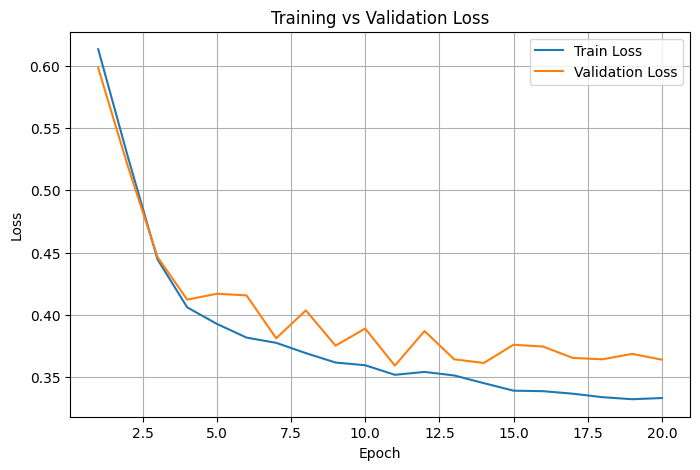

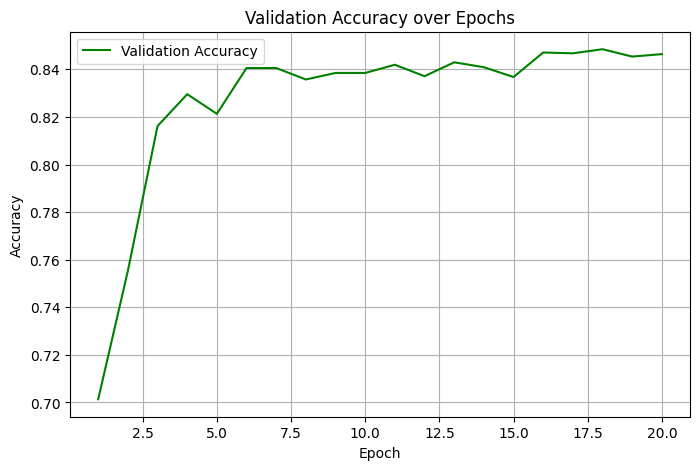

In [18]:

import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

# Plot Loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Plot Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_acc_list, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Over the 20 training epochs, 
- the training loss decreases steadily from 0.61 to around 0.33, indicating that the model is consistently learning useful sequence features that help separate QKI-bound from unbound sequences.
- the validation loss also decreases from ~0.60 to ~0.36, following the same general downward trend as the training loss despite some fluctuations.

### Tuning Hyperparameters

In this section, we will tune the hyper-parameters of the model in an automated way using Optuna. 

**Question: Why is it important to tune hyper-parameters?**

1. Hyper-parameters strongly influence model performance, generalization, and training stability.
2. Proper tuning helps the model learn meaningful patterns instead of underfitting or overfitting.
3. Automated tuning efficiently searches for the best settings such as learning rate, dropout, or number of filters that maximize validation performance.

**Task 8:** 

Read the Optuna manual and create a hyper-model by adjusting your previous model-construction function. 

Explore the effects of combintations of the following configurations:



*   First-layer 1D Conv Kernel Numbers: [32, 64, 96, 128]
*   First-layer 1D Conv Kernel Sizes: [4, 8, 12]
*   Optimizers: ['Adam', 'RMSprop', 'SGD]


*Hint: Use* `hp.Int()` *and* `hp.Choice`.


In [21]:
import optuna
import torch.optim as optim

In [22]:
# 1) First, make your model constructor accept the hyperparameters you want to tune:

class RBP_binding_motif(nn.Module):
    def __init__(
        self,
        conv1_filters: int = 64,
        conv1_kernel_size: int = 9,
        hidden_dim: int = 128,
        dropout_p: float = 0.5,
    ):
        super(RBP_binding_motif, self).__init__()

        self.num_filters = conv1_filters
        self.kernel_size_1 = conv1_kernel_size
        self.kernel_size_2 = 4
        self.hidden_dim = hidden_dim
        self.dropout_p = dropout_p

        # input: (N, 4, 150)
        self.conv1 = nn.Conv1d(
            in_channels=4,
            out_channels=self.num_filters,
            kernel_size=self.kernel_size_1
        )
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(
            in_channels=self.num_filters,
            out_channels=self.num_filters,
            kernel_size=self.kernel_size_2
        )
        self.dropout2 = nn.Dropout(self.dropout_p)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(
            in_channels=self.num_filters,
            out_channels=self.num_filters,
            kernel_size=self.kernel_size_2
        )
        self.dropout3 = nn.Dropout(self.dropout_p)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Dynamically compute the flattened dimension (since kernel_size_1 varies)
        with torch.no_grad():
            dummy = torch.zeros(1, 4, 150)  # (batch=1, channels=4, length=150)
            x = self.pool1(F.relu(self.conv1(dummy)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = self.pool3(F.relu(self.conv3(x)))
            self.flatten_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, self.hidden_dim)
        self.dropout4 = nn.Dropout(self.dropout_p)
        self.fc_out = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        # x: (batch_size, seq_len=150, channels=4)
        x = x.permute(0, 2, 1)  # (B, 4, 150)

        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.dropout3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        
        x = torch.sigmoid(self.fc_out(x)).squeeze(1)
        return x

        # if you haven't included enough hyperparameters in the init definition above, define it here.

In [23]:
# 2) Define an Optuna objective that builds, trains for a few epochs, and returns val_loss:

def objective(trial):
    dropout     = trial.suggest_float("dropout", 0.1, 0.5)
    hidden_size = trial.suggest_int("hidden_size", 64, 256)
    lr          = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    # 3 more to test
    conv1_filters      = trial.suggest_categorical("conv1_filters", [32, 64, 96, 128])
    conv1_kernel_size  = trial.suggest_categorical("conv1_kernel_size", [4, 8, 12])
    opt_name           = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    # --- build model, loss, optimizer ---
    model = RBP_binding_motif(
        conv1_filters=conv1_filters,
        conv1_kernel_size=conv1_kernel_size,
        hidden_dim=hidden_size,
        dropout_p=dropout
    ).to(DEVICE)

    criterion = nn.BCELoss()

    if opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:  # "SGD"
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # --- train/val loop ---
    NUM_EPOCHS = 10 

    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_X, batch_Y in train_loader:
            batch_X = batch_X.to(DEVICE)
            batch_Y = batch_Y.float().to(DEVICE)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # evaluate on validation set
    model.eval()
    running_val = 0.0
    count = 0

    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X = batch_X.to(DEVICE)
            batch_Y = batch_Y.float().to(DEVICE)

            outputs = model(batch_X)
            vloss = criterion(outputs, batch_Y)

            batch_size = batch_X.size(0)
            running_val += vloss.item() * batch_size
            count += batch_size

    return running_val / count  # average validation loss


N_TRIALS = 10

# 3) Run the search:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS)

print("Best params:", study.best_params)

# 4) Rebuild your best model and (optionally) do a full train on train+val, then test:
best_hp = study.best_params

best_model = RBP_binding_motif(
    conv1_filters     = best_hp["conv1_filters"],
    conv1_kernel_size = best_hp["conv1_kernel_size"],
    hidden_dim        = best_hp["hidden_size"],
    dropout_p         = best_hp["dropout"],
).to(DEVICE)

# (re)train best_model on train+val here, then…


[I 2025-11-29 16:52:09,833] A new study created in memory with name: no-name-a5073de2-18f7-4ed2-9d5e-4b8e47bbb4a6
C:\Users\Yang Guo\AppData\Local\Temp\ipykernel_101540\2987306809.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr          = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-11-29 16:53:16,866] Trial 0 finished with value: 0.6032153571184559 and parameters: {'dropout': 0.17270203016896762, 'hidden_size': 102, 'lr': 0.0007489732424211242, 'conv1_filters': 96, 'conv1_kernel_size': 4, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6032153571184559.
[I 2025-11-29 16:54:22,773] Trial 1 finished with value: 0.39215891008934206 and parameters: {'dropout': 0.3019734576037958, 'hidden_size': 174, 'lr': 0.007884752298455066, 'conv1_filters': 96, 'conv1_kernel_size': 4, 'optimizer': 'SGD'}. Best is trial 1 with val

Best params: {'dropout': 0.3019734576037958, 'hidden_size': 174, 'lr': 0.007884752298455066, 'conv1_filters': 96, 'conv1_kernel_size': 4, 'optimizer': 'SGD'}


### Retrain the model with optimized parameters

In [24]:
from torch.utils.data import ConcatDataset, DataLoader

best_hp = study.best_params
print(best_hp)

# 1) Rebuild the model
best_model = RBP_binding_motif(
    conv1_filters     = best_hp["conv1_filters"],
    conv1_kernel_size = best_hp["conv1_kernel_size"],
    hidden_dim        = best_hp["hidden_size"],
    dropout_p         = best_hp["dropout"],
).to(DEVICE)

criterion = nn.BCELoss()

# 2) Define the optimizer in terms of best optimizer and lr
lr = best_hp["lr"]
opt_name = best_hp["optimizer"]

if opt_name == "Adam":
    optimizer = optim.Adam(best_model.parameters(), lr=lr)
elif opt_name == "RMSprop":
    optimizer = optim.RMSprop(best_model.parameters(), lr=lr)
else:  # "SGD"
    optimizer = optim.SGD(best_model.parameters(), lr=lr, momentum=0.9)

# 3) concat train + val dataset
trainval_dataset = ConcatDataset([dataset_train, dataset_val])
trainval_loader = DataLoader(trainval_dataset, batch_size=32, shuffle=True)

# 4) retrain model
num_epochs = 20
for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0

    for batch_X, batch_Y in trainval_loader:
        batch_X = batch_X.to(DEVICE)
        batch_Y = batch_Y.float().to(DEVICE)

        outputs = best_model(batch_X)          
        loss = criterion(outputs, batch_Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(trainval_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train+Val Loss: {epoch_loss:.4f}")


{'dropout': 0.3019734576037958, 'hidden_size': 174, 'lr': 0.007884752298455066, 'conv1_filters': 96, 'conv1_kernel_size': 4, 'optimizer': 'SGD'}
Epoch 1/20 - Train+Val Loss: 0.6386
Epoch 2/20 - Train+Val Loss: 0.5538
Epoch 3/20 - Train+Val Loss: 0.4649
Epoch 4/20 - Train+Val Loss: 0.4032
Epoch 5/20 - Train+Val Loss: 0.3801
Epoch 6/20 - Train+Val Loss: 0.3687
Epoch 7/20 - Train+Val Loss: 0.3645
Epoch 8/20 - Train+Val Loss: 0.3570
Epoch 9/20 - Train+Val Loss: 0.3454
Epoch 10/20 - Train+Val Loss: 0.3479
Epoch 11/20 - Train+Val Loss: 0.3416
Epoch 12/20 - Train+Val Loss: 0.3391
Epoch 13/20 - Train+Val Loss: 0.3272
Epoch 14/20 - Train+Val Loss: 0.3236
Epoch 15/20 - Train+Val Loss: 0.3200
Epoch 16/20 - Train+Val Loss: 0.3103
Epoch 17/20 - Train+Val Loss: 0.3067
Epoch 18/20 - Train+Val Loss: 0.3134
Epoch 19/20 - Train+Val Loss: 0.3002
Epoch 20/20 - Train+Val Loss: 0.2931


In [25]:
# Make sure you already have: dataset_test
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

best_model.eval()
test_running_loss = 0.0
test_correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(DEVICE)
        batch_Y = batch_Y.float().to(DEVICE)

        # Forward
        outputs = best_model(batch_X)   # (B,) probability
        loss = criterion(outputs, batch_Y)

        # Accumulate test loss
        test_running_loss += loss.item() * batch_X.size(0)

        # Compute accuracy
        preds = (outputs > 0.5).float()
        test_correct += (preds == batch_Y).sum().item()
        total += batch_X.size(0)

# Final metrics
test_loss = test_running_loss / total
test_acc = test_correct / total

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Loss: 0.3433
Final Test Accuracy: 0.8437


In [23]:
# Evaluating the best model
